# Thesis Notebook Fake News Detection
Documentation of experiments

In [2]:
# has to run when first running notebook in new environment:
# import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

In [1]:
# Data
import pandas as pd
import xmltodict
import os

# calculations
from numpy.random import seed
import numpy as np
from math import sqrt

# Viz
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

# data preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

# model training
from sklearn.model_selection import train_test_split

# models
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import BernoulliRBM, MLPClassifier

# evaluation
from sklearn.metrics import accuracy_score


# Setting seeds for reproducability
seed(123)

In [3]:
# Parsing articles
# https://zenodo.org/record/1239675#.XbifCuhKguU

def xml_df(xml):
    return pd.DataFrame(xml).loc[['mainText','veracity']].T.reset_index(drop = True)

buzzfeed_16_list = []
for article in os.listdir('./data/articles/articles'):
    with open('./data/articles/articles/'+article, encoding="utf-8") as fd:
        doc_df = xml_df(xmltodict.parse(fd.read()))
        buzzfeed_16_list.append(doc_df)

buzzfeed_16 = pd.concat(buzzfeed_16_list, ignore_index = True)

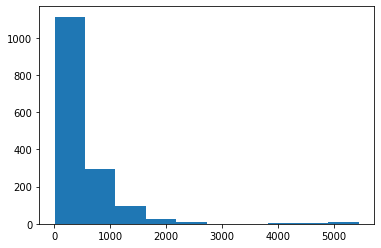

In [4]:
buzzfeed_16.dropna(how = 'any', inplace = True)
buzzfeed_16.drop_duplicates(subset = "mainText", inplace = True)
#buzzfeed_16.to_csv("buzzfeed_16.csv", sep = ",", encoding = "utf-8")
texts = buzzfeed_16.mainText
text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

In [7]:
print(np.mean(text_lengths))
print(np.median(text_lengths))

563.1881824020552
413.0


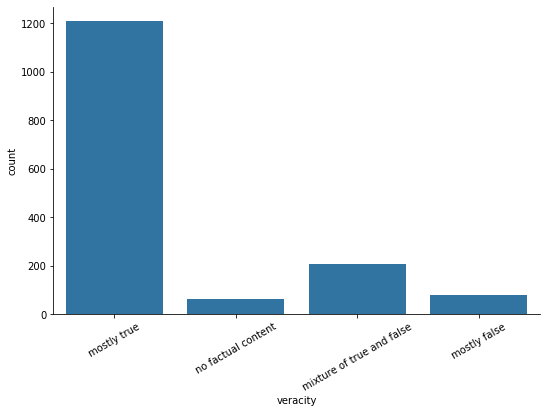

In [14]:
g = sns.factorplot("veracity", data=buzzfeed_16, aspect=1.5, kind="count", color="#1f77b4")
g.set_xticklabels(rotation=30)

In [26]:
buzzfeed_16.veracity.value_counts()/1557*100

mostly true                  77.649326
mixture of true and false    13.294798
mostly false                  5.138086
no factual content            3.917791
Name: veracity, dtype: float64

In [12]:
texts = buzzfeed_16['mainText']
labels = buzzfeed_16['veracity']

print('Found %s texts.' %texts.shape[0])

Found 1557 texts.


## Data Preparation

In [13]:
# set up vector models for training and testing
# Using only 2000 most used words. Guan et al. 2016 used 2k for a vocabulary of 18k words 

max_features = 2000
        
stopWords = set(stopwords.words('english'))

# Defining own tokenizer after sklearn example to have lemmentization

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in stopWords]

# initializing vectorizer

vectorizer = CountVectorizer(tokenizer = LemmaTokenizer(),
                             binary = True, 
                             min_df = 2, 
                             max_features = max_features)

# Fitting vectorizer
docarray = vectorizer.fit_transform(texts).toarray()
docterm = pd.DataFrame(docarray, columns=vectorizer.get_feature_names())

In [14]:
docterm.shape

(1557, 2000)

In [20]:
import sklearn

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    
    # balanced test
    test_bal_acc = sklearn.metrics.balanced_accuracy_score(y_test, y_predict_test)
    # F1 test
    test_f1 = sklearn.metrics.f1_score(y_test, y_predict_test, average = "weighted")
    
    return train_acc, test_acc, test_bal_acc, test_f1

In [16]:
def error_conf(error, n):
    term = 1.96*sqrt((error*(1-error))/n)
    lb = error - term
    ub = error + term
    
    return lb, ub

In [17]:
# create training and test data
TEST_SPLIT = 0.3

docterm_train, docterm_test, y_train, y_test = train_test_split(docterm, labels,
                                                                test_size=TEST_SPLIT,
                                                                random_state = 123)

# Finetuning data is 15% of the whole dataset
#docterm_fine, docterm_test, y_fine, y_test = train_test_split(docterm_test,
#                                                              y_test,
#                                                              test_size = 0.5,
#                                                              random_state = 123)

## Naive Bayes

In [18]:
model = MultinomialNB()
model.fit(docterm_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [21]:
# evaluate model with pre defined functions

train_acc, test_acc, test_bal_acc, test_f1 = evaluate_model(model.predict, docterm_train, y_train, docterm_test, y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
print("Testing Balanced Accuracy: {:.2f}%".format(test_bal_acc*100))
print("Testing F1 Score: {:.2f}%".format(test_f1*100))

Training Accuracy: 81.18%
Testing Accuracy: 64.32%
Testing Balanced Accuracy: 40.26%
Testing F1 Score: 67.87%


In [22]:
n = docterm_test.shape[0]
lb, ub = error_conf(1-test_bal_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 35.82%-44.70%


## KNN - Benchmark

In [24]:
knc = KNeighborsClassifier(2)

knc.fit(docterm_train, y_train)

train_acc, test_acc, test_bal_acc, test_f1  = evaluate_model(knc.predict, docterm_train, y_train, docterm_test, y_test)

print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
print("Testing Balanced Accuracy: {:.2f}%".format(test_bal_acc*100))
print("Testing F1 Score: {:.2f}%".format(test_f1*100))

Training Accuracy: 96.79%
Testing Accuracy: 71.79%
Testing Balanced Accuracy: 33.87%
Testing F1 Score: 68.37%


## SVM - Benchmark

In [44]:
svc_ = SVC(random_state = 123, class_weight = "balanced")

svc_.fit(docterm_train, y_train)

train_acc, test_acc, test_bal_acc, test_f1  = evaluate_model(svc_.predict, docterm_train, y_train, docterm_test, y_test)

print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
print("Testing Balanced Accuracy: {:.2f}%".format(test_bal_acc*100))
print("Testing F1 Score: {:.2f}%".format(test_f1*100))

c:\users\jakla\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training Accuracy: 57.30%
Testing Accuracy: 44.44%
Testing Balanced Accuracy: 39.29%
Testing F1 Score: 53.39%


## RBM

In [61]:
# Using the sci-kit learn implementation for Restricted Boltzman Machines


#RBM params
learning_rate = 0.03 
total_units   =  2000 
total_epochs  =   200 
batch_size    =  30

# initializing RBM
rbm = BernoulliRBM(n_components=total_units,
                   learning_rate=learning_rate,
                   batch_size=batch_size,
                   n_iter=total_epochs,
                   verbose=1,
                   random_state = 123)
# fitting RBM
history_rbm = rbm.fit(docterm_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -752.49, time = 3.50s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -620.16, time = 3.77s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -683.67, time = 3.90s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -702.25, time = 3.82s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -657.25, time = 3.80s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -587.08, time = 3.80s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -569.78, time = 3.80s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -561.27, time = 3.82s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -589.14, time = 3.80s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -555.94, time = 3.78s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -527.51, time = 3.82s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -507.83, time = 3.82s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -504.39, time = 3.81s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -504.31, time = 3.82s
[BernoulliRBM] 

[BernoulliRBM] Iteration 117, pseudo-likelihood = -167.14, time = 3.82s
[BernoulliRBM] Iteration 118, pseudo-likelihood = -171.05, time = 3.83s
[BernoulliRBM] Iteration 119, pseudo-likelihood = -156.26, time = 3.81s
[BernoulliRBM] Iteration 120, pseudo-likelihood = -154.02, time = 3.85s
[BernoulliRBM] Iteration 121, pseudo-likelihood = -157.23, time = 3.81s
[BernoulliRBM] Iteration 122, pseudo-likelihood = -155.76, time = 3.96s
[BernoulliRBM] Iteration 123, pseudo-likelihood = -148.16, time = 3.85s
[BernoulliRBM] Iteration 124, pseudo-likelihood = -147.14, time = 3.87s
[BernoulliRBM] Iteration 125, pseudo-likelihood = -156.10, time = 3.81s
[BernoulliRBM] Iteration 126, pseudo-likelihood = -143.14, time = 3.80s
[BernoulliRBM] Iteration 127, pseudo-likelihood = -143.35, time = 3.82s
[BernoulliRBM] Iteration 128, pseudo-likelihood = -157.31, time = 3.84s
[BernoulliRBM] Iteration 129, pseudo-likelihood = -141.47, time = 3.83s
[BernoulliRBM] Iteration 130, pseudo-likelihood = -147.26, time 

In [ ]:
transformed_train = rbm.transform(docterm_train)
transformed_test = rbm.transform(docterm_test)

In [99]:
# MLP

from sklearn.neural_network import MLPClassifier
le = LabelEncoder()
le.fit(labels)

mlp = MLPClassifier(hidden_layer_sizes= (10, 4), activation = 'relu', solver = 'lbfgs', random_state = 199)

mlp.fit(transformed_train, le.transform(y_train))

train_acc, test_acc, test_bal_acc, test_f1  = evaluate_model(mlp.predict, transformed_train, le.transform(y_train), transformed_test, le.transform(y_test))
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
print("Testing Balanced Accuracy: {:.2f}%".format(test_bal_acc*100))
print("Testing F1 Score: {:.2f}%".format(test_f1*100))

Training Accuracy: 98.07%
Testing Accuracy: 75.21%
Testing Balanced Accuracy: 40.08%
Testing F1 Score: 74.23%


# RUN 2 comparing RBMs by iterations

In [101]:
# Second run: Comparing RBM iterations
from sklearn.pipeline import Pipeline

results_rbm = {}
epoch_list = [10, 50, 100, 200, 300]

for i in epoch_list:
    

    rbm_2 = BernoulliRBM(n_components=total_units,
                       learning_rate=learning_rate,
                       batch_size=batch_size,
                       n_iter= i,
                       verbose=1,
                       random_state = 123)

    mlp_2 = MLPClassifier(hidden_layer_sizes= (10, 4), activation = 'relu', solver = 'lbfgs', random_state = 199)

    softmax = Pipeline(memory = None, steps = [('rbm_2', rbm_2), ('mlp', mlp_2)])

    softmax.fit(docterm_train, le.transform(y_train))

    train_acc, test_acc, test_bal_acc, test_f1  = evaluate_model(softmax.predict, docterm_train, le.transform(y_train), docterm_test, le.transform(y_test))
    print("Testing F1 Score: {:.2f}%".format(test_f1*100))
    results_rbm[str(i)+" iters"] = test_f1

[BernoulliRBM] Iteration 1, pseudo-likelihood = -752.49, time = 3.56s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -620.16, time = 3.72s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -683.67, time = 3.73s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -702.25, time = 3.74s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -657.25, time = 3.72s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -587.08, time = 3.78s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -569.78, time = 3.78s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -561.27, time = 3.95s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -589.14, time = 3.99s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -555.94, time = 3.82s
Testing F1 Score: 72.97%
[BernoulliRBM] Iteration 1, pseudo-likelihood = -752.49, time = 3.54s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -620.16, time = 3.77s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -683.67, time = 3.74s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -702.25, time = 

[BernoulliRBM] Iteration 57, pseudo-likelihood = -312.34, time = 3.93s
[BernoulliRBM] Iteration 58, pseudo-likelihood = -299.19, time = 3.87s
[BernoulliRBM] Iteration 59, pseudo-likelihood = -306.32, time = 3.86s
[BernoulliRBM] Iteration 60, pseudo-likelihood = -285.12, time = 3.82s
[BernoulliRBM] Iteration 61, pseudo-likelihood = -286.28, time = 3.81s
[BernoulliRBM] Iteration 62, pseudo-likelihood = -286.02, time = 3.90s
[BernoulliRBM] Iteration 63, pseudo-likelihood = -284.25, time = 3.80s
[BernoulliRBM] Iteration 64, pseudo-likelihood = -289.30, time = 3.80s
[BernoulliRBM] Iteration 65, pseudo-likelihood = -278.76, time = 3.80s
[BernoulliRBM] Iteration 66, pseudo-likelihood = -292.42, time = 3.79s
[BernoulliRBM] Iteration 67, pseudo-likelihood = -272.64, time = 3.80s
[BernoulliRBM] Iteration 68, pseudo-likelihood = -270.29, time = 3.79s
[BernoulliRBM] Iteration 69, pseudo-likelihood = -275.91, time = 3.79s
[BernoulliRBM] Iteration 70, pseudo-likelihood = -270.25, time = 3.82s
[Berno

c:\users\jakla\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Testing F1 Score: 73.84%
[BernoulliRBM] Iteration 1, pseudo-likelihood = -752.49, time = 3.66s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -620.16, time = 3.94s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -683.67, time = 3.93s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -702.25, time = 3.89s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -657.25, time = 3.88s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -587.08, time = 3.86s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -569.78, time = 3.86s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -561.27, time = 3.88s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -589.14, time = 3.88s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -555.94, time = 3.90s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -527.51, time = 3.86s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -507.83, time = 3.88s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -504.39, time = 3.85s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -504.31, tim

[BernoulliRBM] Iteration 116, pseudo-likelihood = -162.51, time = 3.91s
[BernoulliRBM] Iteration 117, pseudo-likelihood = -167.14, time = 3.91s
[BernoulliRBM] Iteration 118, pseudo-likelihood = -171.05, time = 3.92s
[BernoulliRBM] Iteration 119, pseudo-likelihood = -156.26, time = 3.90s
[BernoulliRBM] Iteration 120, pseudo-likelihood = -154.02, time = 3.91s
[BernoulliRBM] Iteration 121, pseudo-likelihood = -157.23, time = 3.92s
[BernoulliRBM] Iteration 122, pseudo-likelihood = -155.76, time = 3.90s
[BernoulliRBM] Iteration 123, pseudo-likelihood = -148.16, time = 3.90s
[BernoulliRBM] Iteration 124, pseudo-likelihood = -147.14, time = 3.91s
[BernoulliRBM] Iteration 125, pseudo-likelihood = -156.10, time = 3.90s
[BernoulliRBM] Iteration 126, pseudo-likelihood = -143.14, time = 3.90s
[BernoulliRBM] Iteration 127, pseudo-likelihood = -143.35, time = 3.91s
[BernoulliRBM] Iteration 128, pseudo-likelihood = -157.31, time = 3.90s
[BernoulliRBM] Iteration 129, pseudo-likelihood = -141.47, time 

[BernoulliRBM] Iteration 31, pseudo-likelihood = -373.33, time = 4.32s
[BernoulliRBM] Iteration 32, pseudo-likelihood = -360.58, time = 4.29s
[BernoulliRBM] Iteration 33, pseudo-likelihood = -370.58, time = 4.29s
[BernoulliRBM] Iteration 34, pseudo-likelihood = -357.98, time = 4.33s
[BernoulliRBM] Iteration 35, pseudo-likelihood = -363.77, time = 4.31s
[BernoulliRBM] Iteration 36, pseudo-likelihood = -364.04, time = 4.30s
[BernoulliRBM] Iteration 37, pseudo-likelihood = -363.60, time = 4.31s
[BernoulliRBM] Iteration 38, pseudo-likelihood = -358.16, time = 4.29s
[BernoulliRBM] Iteration 39, pseudo-likelihood = -348.91, time = 4.31s
[BernoulliRBM] Iteration 40, pseudo-likelihood = -353.09, time = 4.32s
[BernoulliRBM] Iteration 41, pseudo-likelihood = -333.03, time = 4.30s
[BernoulliRBM] Iteration 42, pseudo-likelihood = -332.55, time = 4.29s
[BernoulliRBM] Iteration 43, pseudo-likelihood = -345.38, time = 4.32s
[BernoulliRBM] Iteration 44, pseudo-likelihood = -332.95, time = 4.31s
[Berno

[BernoulliRBM] Iteration 146, pseudo-likelihood = -124.19, time = 4.23s
[BernoulliRBM] Iteration 147, pseudo-likelihood = -111.53, time = 4.28s
[BernoulliRBM] Iteration 148, pseudo-likelihood = -111.49, time = 4.33s
[BernoulliRBM] Iteration 149, pseudo-likelihood = -124.35, time = 4.32s
[BernoulliRBM] Iteration 150, pseudo-likelihood = -115.58, time = 4.27s
[BernoulliRBM] Iteration 151, pseudo-likelihood = -122.55, time = 4.29s
[BernoulliRBM] Iteration 152, pseudo-likelihood = -116.67, time = 4.30s
[BernoulliRBM] Iteration 153, pseudo-likelihood = -116.41, time = 4.30s
[BernoulliRBM] Iteration 154, pseudo-likelihood = -114.26, time = 4.29s
[BernoulliRBM] Iteration 155, pseudo-likelihood = -110.80, time = 4.28s
[BernoulliRBM] Iteration 156, pseudo-likelihood = -112.93, time = 4.32s
[BernoulliRBM] Iteration 157, pseudo-likelihood = -105.58, time = 4.34s
[BernoulliRBM] Iteration 158, pseudo-likelihood = -106.84, time = 4.29s
[BernoulliRBM] Iteration 159, pseudo-likelihood = -115.57, time 

[BernoulliRBM] Iteration 262, pseudo-likelihood = -36.66, time = 3.80s
[BernoulliRBM] Iteration 263, pseudo-likelihood = -37.32, time = 3.76s
[BernoulliRBM] Iteration 264, pseudo-likelihood = -43.51, time = 3.72s
[BernoulliRBM] Iteration 265, pseudo-likelihood = -49.29, time = 3.81s
[BernoulliRBM] Iteration 266, pseudo-likelihood = -38.34, time = 3.74s
[BernoulliRBM] Iteration 267, pseudo-likelihood = -36.25, time = 3.72s
[BernoulliRBM] Iteration 268, pseudo-likelihood = -42.79, time = 3.75s
[BernoulliRBM] Iteration 269, pseudo-likelihood = -46.77, time = 3.73s
[BernoulliRBM] Iteration 270, pseudo-likelihood = -44.37, time = 3.76s
[BernoulliRBM] Iteration 271, pseudo-likelihood = -53.34, time = 3.74s
[BernoulliRBM] Iteration 272, pseudo-likelihood = -43.82, time = 3.72s
[BernoulliRBM] Iteration 273, pseudo-likelihood = -41.95, time = 3.75s
[BernoulliRBM] Iteration 274, pseudo-likelihood = -36.35, time = 3.73s
[BernoulliRBM] Iteration 275, pseudo-likelihood = -37.30, time = 3.74s
[Berno

In [105]:
iterations_rbm = pd.DataFrame(results_rbm, index = [0])
iterations_rbm

,10 iters,50 iters,100 iters,200 iters,300 iters
0,0.729728,0.745792,0.738357,0.742269,0.737127


# Run 3: RBM with other models

In [92]:
model_list = [model, knc, svc_, mlp]

rbm_combo_results = {}

for i in model_list:
    print(i)
    i.fit(transformed_train, le.transform(y_train))
    train_acc, test_acc, test_bal_acc, test_f1  = evaluate_model(i.predict, transformed_train, le.transform(y_train), transformed_test, le.transform(y_test))
    rbm_combo_results[i] = {'test_acc' : test_acc,
                                'test_f1' : test_f1}
    

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=2,
    shrinking=True, tol=0.001, verbose=False)


c:\users\jakla\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 4), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=199, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


In [94]:
rbm_combo_results_df = pd.DataFrame(rbm_combo_results).T
rbm_combo_results_df

,test_acc,test_f1
"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",0.600427,0.652385
"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n metric_params=None, n_jobs=None, n_neighbors=2, p=2,\n weights='uniform')",0.786325,0.718447
"SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,\n decision_function_shape='ovr', degree=3, gamma='auto_deprecated',\n kernel='rbf', max_iter=-1, probability=False, random_state=2,\n shrinking=True, tol=0.001, verbose=False)",0.615385,0.663752
"MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,\n beta_2=0.999, early_stopping=False, epsilon=1e-08,\n hidden_layer_sizes=(10, 4), learning_rate='constant',\n learning_rate_init=0.001, max_iter=200, momentum=0.9,\n n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,\n random_state=199, shuffle=True, solver='lbfgs', tol=0.0001,\n validation_fraction=0.1, verbose=False, warm_start=False)",0.752137,0.742269


In [83]:
# Models without RBM for comparison:

In [81]:
model_list = [model, knc, svc_]

combo_results = {}

for i in model_list:
    print(i)
    i.fit(docterm_train, le.transform(y_train))
    train_acc, test_acc, test_bal_acc, test_f1  = evaluate_model(i.predict, docterm_train, le.transform(y_train), docterm_test, le.transform(y_test))
    combo_results[i] = {'test_acc' : test_acc,
                                'test_f1' : test_f1}

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
0.6786889824678304
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')
0.6836889986901196
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=2,
    shrinking=True, tol=0.001, verbose=False)


c:\users\jakla\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5338896966543584


In [95]:
combo_results_df = pd.DataFrame(combo_results).T
combo_results_df

,test_acc,test_f1
"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",0.643162,0.678689
"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n metric_params=None, n_jobs=None, n_neighbors=2, p=2,\n weights='uniform')",0.717949,0.683689
"SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,\n decision_function_shape='ovr', degree=3, gamma='auto_deprecated',\n kernel='rbf', max_iter=-1, probability=False, random_state=2,\n shrinking=True, tol=0.001, verbose=False)",0.444444,0.533890


In [85]:
## DBN No 1 [2000 2000]

rbm_dbn_2 = BernoulliRBM(n_components=2000,
                       learning_rate=learning_rate,
                       batch_size=batch_size,
                       n_iter= 200,
                       verbose=1,
                       random_state = 123)

dbn_1 = rbm_dbn_2.fit(transformed_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -694.75, time = 3.51s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -652.01, time = 3.75s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -643.66, time = 3.73s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -681.53, time = 3.71s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -629.35, time = 3.73s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -595.81, time = 3.79s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -573.02, time = 3.80s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -555.31, time = 3.74s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -533.56, time = 3.75s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -523.07, time = 3.79s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -534.46, time = 3.73s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -518.17, time = 3.77s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -498.43, time = 3.78s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -482.65, time = 3.74s
[BernoulliRBM] 

[BernoulliRBM] Iteration 117, pseudo-likelihood = -158.57, time = 3.80s
[BernoulliRBM] Iteration 118, pseudo-likelihood = -164.95, time = 3.79s
[BernoulliRBM] Iteration 119, pseudo-likelihood = -158.99, time = 3.81s
[BernoulliRBM] Iteration 120, pseudo-likelihood = -160.17, time = 3.79s
[BernoulliRBM] Iteration 121, pseudo-likelihood = -155.34, time = 3.80s
[BernoulliRBM] Iteration 122, pseudo-likelihood = -153.59, time = 3.81s
[BernoulliRBM] Iteration 123, pseudo-likelihood = -154.96, time = 3.80s
[BernoulliRBM] Iteration 124, pseudo-likelihood = -155.84, time = 3.79s
[BernoulliRBM] Iteration 125, pseudo-likelihood = -151.53, time = 3.78s
[BernoulliRBM] Iteration 126, pseudo-likelihood = -154.13, time = 3.79s
[BernoulliRBM] Iteration 127, pseudo-likelihood = -157.04, time = 3.80s
[BernoulliRBM] Iteration 128, pseudo-likelihood = -152.40, time = 3.81s
[BernoulliRBM] Iteration 129, pseudo-likelihood = -155.45, time = 3.78s
[BernoulliRBM] Iteration 130, pseudo-likelihood = -151.61, time 

In [86]:
## DBN No 2 [2000 1000]

rbm_dbn_3 = BernoulliRBM(n_components=1000,
                       learning_rate=learning_rate,
                       batch_size=batch_size,
                       n_iter= 200,
                       verbose=1,
                       random_state = 123)
                       
dbn_2 = rbm_dbn_3.fit(transformed_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -719.89, time = 1.71s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -661.59, time = 1.85s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -653.51, time = 1.84s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -608.64, time = 1.84s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -602.48, time = 1.84s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -629.75, time = 1.89s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -566.82, time = 1.84s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -553.64, time = 1.84s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -541.36, time = 1.84s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -535.65, time = 1.85s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -516.96, time = 1.85s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -510.24, time = 1.85s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -513.39, time = 1.84s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -495.90, time = 1.84s
[BernoulliRBM] 

[BernoulliRBM] Iteration 117, pseudo-likelihood = -190.13, time = 1.83s
[BernoulliRBM] Iteration 118, pseudo-likelihood = -190.15, time = 1.84s
[BernoulliRBM] Iteration 119, pseudo-likelihood = -185.27, time = 1.85s
[BernoulliRBM] Iteration 120, pseudo-likelihood = -187.13, time = 1.83s
[BernoulliRBM] Iteration 121, pseudo-likelihood = -183.21, time = 1.85s
[BernoulliRBM] Iteration 122, pseudo-likelihood = -184.79, time = 1.85s
[BernoulliRBM] Iteration 123, pseudo-likelihood = -187.43, time = 1.84s
[BernoulliRBM] Iteration 124, pseudo-likelihood = -183.24, time = 1.85s
[BernoulliRBM] Iteration 125, pseudo-likelihood = -180.52, time = 1.85s
[BernoulliRBM] Iteration 126, pseudo-likelihood = -184.21, time = 1.84s
[BernoulliRBM] Iteration 127, pseudo-likelihood = -177.91, time = 1.84s
[BernoulliRBM] Iteration 128, pseudo-likelihood = -176.06, time = 1.84s
[BernoulliRBM] Iteration 129, pseudo-likelihood = -178.51, time = 1.87s
[BernoulliRBM] Iteration 130, pseudo-likelihood = -179.66, time 

In [87]:
## DBN No 3 [2000 1000 500]

transformed_train_2 = dbn_2.transform(transformed_train)

rbm_dbn_4 = BernoulliRBM(n_components=500,
                       learning_rate=learning_rate,
                       batch_size=batch_size,
                       n_iter= 200,
                       verbose=1,
                       random_state = 123)
                       
dbn_3 = rbm_dbn_4.fit(transformed_train_2)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -385.09, time = 0.34s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -377.64, time = 0.40s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -373.23, time = 0.40s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -367.24, time = 0.41s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -354.10, time = 0.40s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -344.36, time = 0.42s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -341.13, time = 0.40s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -331.07, time = 0.40s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -328.15, time = 0.40s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -312.27, time = 0.41s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -313.34, time = 0.40s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -304.48, time = 0.40s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -301.55, time = 0.41s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -295.04, time = 0.41s
[BernoulliRBM] 

[BernoulliRBM] Iteration 117, pseudo-likelihood = -115.82, time = 0.40s
[BernoulliRBM] Iteration 118, pseudo-likelihood = -118.49, time = 0.42s
[BernoulliRBM] Iteration 119, pseudo-likelihood = -115.69, time = 0.40s
[BernoulliRBM] Iteration 120, pseudo-likelihood = -113.82, time = 0.41s
[BernoulliRBM] Iteration 121, pseudo-likelihood = -116.55, time = 0.40s
[BernoulliRBM] Iteration 122, pseudo-likelihood = -115.59, time = 0.40s
[BernoulliRBM] Iteration 123, pseudo-likelihood = -111.72, time = 0.43s
[BernoulliRBM] Iteration 124, pseudo-likelihood = -111.95, time = 0.40s
[BernoulliRBM] Iteration 125, pseudo-likelihood = -113.94, time = 0.41s
[BernoulliRBM] Iteration 126, pseudo-likelihood = -108.78, time = 0.41s
[BernoulliRBM] Iteration 127, pseudo-likelihood = -111.26, time = 0.40s
[BernoulliRBM] Iteration 128, pseudo-likelihood = -107.38, time = 0.41s
[BernoulliRBM] Iteration 129, pseudo-likelihood = -106.34, time = 0.40s
[BernoulliRBM] Iteration 130, pseudo-likelihood = -104.56, time 

In [90]:
# Test Performance of DBN1 [2000 2000]
model_list = [model, knc, svc_, mlp]

transformed_train_dbn1 = dbn_1.transform(transformed_train)
transformed_test_dbn1 = dbn_1.transform(transformed_test)

dbn1_combo_results = {}

for i in model_list:
    print(i)
    i.fit(transformed_train_dbn1, le.transform(y_train))
    train_acc, test_acc, test_bal_acc, test_f1  = evaluate_model(i.predict, transformed_train_dbn1, le.transform(y_train), transformed_test_dbn1, le.transform(y_test))
    dbn1_combo_results[i] = {'test_acc' : test_acc,
                                'test_f1' : test_f1}

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=2,
    shrinking=True, tol=0.001, verbose=False)


c:\users\jakla\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 4), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=199, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


In [96]:
dbn1_combo_results_df = pd.DataFrame(dbn1_combo_results).T
dbn1_combo_results_df

,test_acc,test_f1
"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",0.606838,0.659047
"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n metric_params=None, n_jobs=None, n_neighbors=2, p=2,\n weights='uniform')",0.762821,0.695997
"SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,\n decision_function_shape='ovr', degree=3, gamma='auto_deprecated',\n kernel='rbf', max_iter=-1, probability=False, random_state=2,\n shrinking=True, tol=0.001, verbose=False)",0.476496,0.554650
"MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,\n beta_2=0.999, early_stopping=False, epsilon=1e-08,\n hidden_layer_sizes=(10, 4), learning_rate='constant',\n learning_rate_init=0.001, max_iter=200, momentum=0.9,\n n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,\n random_state=199, shuffle=True, solver='lbfgs', tol=0.0001,\n validation_fraction=0.1, verbose=False, warm_start=False)",0.771368,0.753055


In [97]:
# Test Performance of DBN2 [2000 1000]

transformed_train_dbn2 = dbn_2.transform(transformed_train)
transformed_test_dbn2 = dbn_2.transform(transformed_test)

dbn2_combo_results = {}

for i in model_list:
    print(i)
    i.fit(transformed_train_dbn2, le.transform(y_train))
    train_acc, test_acc, test_bal_acc, test_f1  = evaluate_model(i.predict, transformed_train_dbn2, le.transform(y_train), transformed_test_dbn2, le.transform(y_test))
    dbn2_combo_results[i] = {'test_acc' : test_acc,
                                'test_f1' : test_f1}

dbn2_combo_results_df = pd.DataFrame(dbn2_combo_results).T
dbn2_combo_results_df

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=2,
    shrinking=True, tol=0.001, verbose=False)


c:\users\jakla\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 4), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=199, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


c:\users\jakla\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,test_acc,test_f1
"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",0.602564,0.656081
"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n metric_params=None, n_jobs=None, n_neighbors=2, p=2,\n weights='uniform')",0.756410,0.701589
"SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,\n decision_function_shape='ovr', degree=3, gamma='auto_deprecated',\n kernel='rbf', max_iter=-1, probability=False, random_state=2,\n shrinking=True, tol=0.001, verbose=False)",0.538462,0.617431
"MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,\n beta_2=0.999, early_stopping=False, epsilon=1e-08,\n hidden_layer_sizes=(10, 4), learning_rate='constant',\n learning_rate_init=0.001, max_iter=200, momentum=0.9,\n n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,\n random_state=199, shuffle=True, solver='lbfgs', tol=0.0001,\n validation_fraction=0.1, verbose=False, warm_start=False)",0.730769,0.724235


In [98]:
# Test Performance of DBN3 [2000 1000 500]

transformed_train_dbn3 = dbn_3.transform(transformed_train_dbn2)
transformed_test_dbn3 = dbn_3.transform(transformed_test_dbn2)

dbn3_combo_results = {}

for i in model_list:
    print(i)
    i.fit(transformed_train_dbn3, le.transform(y_train))
    train_acc, test_acc, test_bal_acc, test_f1  = evaluate_model(i.predict, transformed_train_dbn3, le.transform(y_train), transformed_test_dbn3, le.transform(y_test))
    dbn3_combo_results[i] = {'test_acc' : test_acc,
                                'test_f1' : test_f1}

dbn3_combo_results_df = pd.DataFrame(dbn3_combo_results).T
dbn3_combo_results_df

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=2,
    shrinking=True, tol=0.001, verbose=False)


c:\users\jakla\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 4), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=199, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)


,test_acc,test_f1
"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",0.591880,0.651836
"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',\n metric_params=None, n_jobs=None, n_neighbors=2, p=2,\n weights='uniform')",0.728632,0.712699
"SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,\n decision_function_shape='ovr', degree=3, gamma='auto_deprecated',\n kernel='rbf', max_iter=-1, probability=False, random_state=2,\n shrinking=True, tol=0.001, verbose=False)",0.581197,0.645052
"MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,\n beta_2=0.999, early_stopping=False, epsilon=1e-08,\n hidden_layer_sizes=(10, 4), learning_rate='constant',\n learning_rate_init=0.001, max_iter=200, momentum=0.9,\n n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,\n random_state=199, shuffle=True, solver='lbfgs', tol=0.0001,\n validation_fraction=0.1, verbose=False, warm_start=False)",0.730769,0.732389


In [103]:
# Exporting models to save
import pickle

dbn1_piped = Pipeline(memory = None, steps = [('rbm', rbm), ('rbm2000',dbn_1)])
dbn2_piped = Pipeline(memory = None, steps =  [('rbm', rbm), ('rbm1000',dbn_2)])
dbn3_piped = Pipeline(memory = None, steps =  [('rbm', rbm), ('rbm1000',dbn_2), ('rbm500', dbn_3)])

dbns = [dbn1_piped, dbn2_piped, dbn3_piped]

for i, dbn in enumerate(dbns):
    with open("dbn_"+str(i+1)+".mdl", "wb") as handle:
        pickle.dump(dbn, handle)

pickle.dump(rbm, open("rbm.mdl", 'wb'))

In [119]:
# Saving model outputs as csvs


def format_df(df):
    df['Model'] = ["Naive Bayes", "KNN", "SVM", "Softmax"]
    df.reset_index(drop = True, inplace = True)
    df = df.reindex(columns = ['Model', 'test_acc', 'test_f1'])
    return df


res = [rbm_combo_results_df, dbn1_combo_results_df, dbn2_combo_results_df, dbn3_combo_results_df]
for r in res:
    format_df(r)


combo_results_df['Model'] = ["Naive Bayes", "KNN", "SVM"]
combo_results_df.reset_index(drop = True, inplace = True)

In [122]:
iterations_rbm.T.to_csv("RBM_iterations.csv", sep = ",", encoding = 'utf-8')
combo_results_df.to_csv("combo_results.csv", sep = ",", encoding = 'utf-8')
rbm_combo_results_df.to_csv("RBM_combo_results.csv", sep = ",", encoding = 'utf-8')
dbn1_combo_results_df.to_csv("dbn1_combo_results.csv", sep = ",", encoding = 'utf-8')
dbn2_combo_results_df.to_csv("dbn2_combo_results.csv", sep = ",", encoding = 'utf-8')
dbn3_combo_results_df.to_csv("dbn3_combo_results.csv", sep = ",", encoding = 'utf-8')